In [1]:
import mahotas as mh
import numpy as np, matplotlib
from matplotlib import pyplot as plt
from skimage.filters import rank
from skimage.morphology import disk
from skimage.feature import peak_local_max
from skimage.filters import threshold_local
import numpy as np, scipy.ndimage as ndi
import pathlib
matplotlib.rcParams['figure.figsize'] = (8, 8)
plt.gray()

<Figure size 576x576 with 0 Axes>

In [2]:
from scipy.ndimage.morphology import binary_fill_holes

In [3]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [10]:
pathlib.Path(r'C:\Users\Mo\OneDrive\Work_Notes\OBI\CV-Images\ImageProcessing\2.ImageBreaker\tiles_output\HCells_FOV72')

WindowsPath('C:/Users/Mo/OneDrive/Work_Notes/OBI/CV-Images/ImageProcessing/2.ImageBreaker/tiles_output/HCells_FOV72')

In [13]:
# dna = plt.imread(r'Mouse_CV-CellSeg/BC67_DAPI/image/BC67_DAPI.png');  # normal size 2024 x 2024
#dna = plt.imread(r'C:/Users/mymmp/OneDrive/Work_Notes/OBI/CV-Images/ImageProcessing/2.ImageBreaker/tiles_output/HCe');
dna = plt.imread(r'C:/Users/Mo/OneDrive/Work_Notes/OBI/CV-Images/ImageProcessing/2.ImageBreaker/tiles_output/HCells_FOV72/FOV72_DAPI_tile-x2y2.png')
print('stack image shape:',dna.shape)
dna_max = mh.stretch(dna);

stack image shape: (512, 512)


<b> Thresholding & filter

In [14]:
# Gaussian blurring filter
g_img = mh.gaussian_filter(dna_max, 3); g_mean = g_img.mean();   # 3
otsu = mh.otsu(dna_max)
local_img = threshold_local(dna_max, block_size=3)   #25

bin_image_mean = dna_max > otsu
bin_image_gaussian = g_img > otsu  # gaussian otsu
bin_image_local = local_img > mh.otsu(mh.stretch(local_img))

# label the image in order to assign index to each component
labeled, nr_object = mh.label(bin_image_mean); print('Number of objects:',nr_object)

Number of objects: 25


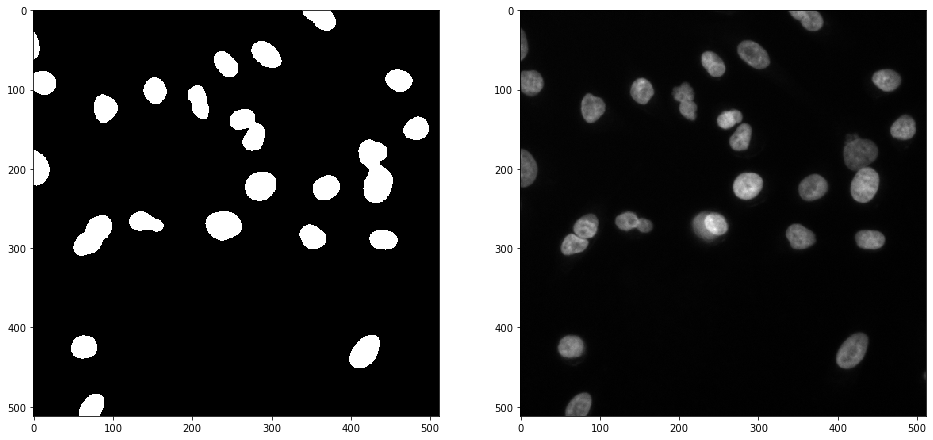

In [15]:
# Choose bin image
bin_image = bin_image_gaussian; 
filtered_img = bin_image*dna_max; 
plt.figure(figsize=(16,8)); plt.subplot(121); plt.imshow(bin_image)
plt.subplot(122); plt.imshow(dna_max)

### Separating touching cells
The general strategy we can use to separate the cells is the following:

1. Smooth the image with a Gaussian filter (we need to specify the  $\sigma$ parameter)
2. Find regional maxima on this smoothed image to identify each cell
3. Use watershed on the distance transformed image to separate cells.

In [16]:
target = dna_max
def Blurg_maximas(blur_factor=13, sigma=0.5, dil4show = 15):    # dilf: dilate factor
    fig = plt.figure(figsize=(12,5)); fig.tight_layout(); 
    # Apply Gaussian-mean mask
    gaussian_f = mh.gaussian_filter(target, sigma = sigma); g_fitler = gaussian_f>gaussian_f.mean()
    ax1 = fig.add_subplot(131); ax1.imshow(target*g_fitler); ax1.set_title('gaussian')
    
    # Blur resultant image
    img_blurred= rank.mean(target, disk(blur_factor)); 
    plt.subplot(132); plt.imshow(img_blurred); plt.title('Blurred')
    gaussian_f = mh.gaussian_filter(img_blurred, sigma = sigma); 
    blurg_filter = gaussian_f>gaussian_f.mean(); filtered_img = img_blurred*blurg_filter;
    
    # Maximas
    maxima = mh.regmax(filtered_img,); 
    maxima_labeled, _ = mh.label(maxima);
    ax2 = fig.add_subplot(133); ax2.imshow(filtered_img); ax2.set_title('Blur then Gaussian (filtered_img)')
    plt.imshow(mh.as_rgb(np.maximum(255*mh.dilate(maxima,np.ones((dil4show,dil4show))), filtered_img), filtered_img, filtered_img > mh.otsu(filtered_img)))
    return g_fitler, img_blurred, blurg_filter, filtered_img, maxima_labeled

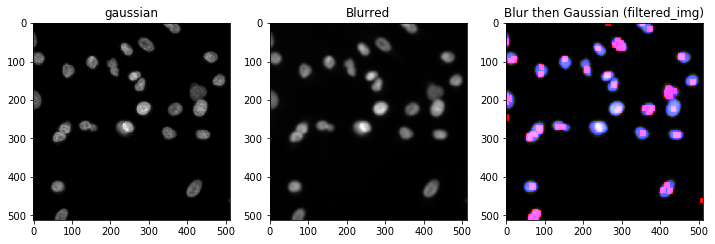

In [17]:
_,_, blurg_filter, filtered_img, maxima_labeled = Blurg_maximas(blur_factor=5,sigma=2)  #16, 0.5

In [18]:
from skimage.measure import regionprops
import matplotlib.patches as mpatches

In [19]:
# QC Functions: methods
def Label_sampler(labeled_objects, xy = 8, num_labels = 100):
    fig = plt.figure(figsize=(5*xy,5*xy)); start = random.randint(1, num_labels-xy**2)
    for n, i in enumerate(range(start, start+xy**2)):
        ax = fig.add_subplot(xy, xy,n+1)
        ax.imshow(labeled_objects==i)
        
# Filter Watershed label by size
def Label_boxer(labeled_objects, min_size = 20, max_size = None, area_record = False):
    fig, ax = plt.subplots(1,1, figsize=(8,8)); ax.imshow(labeled_objects)
    box_coords = {}; area_records = {}
    if not max_size:
        max_size = np.inf
    for region in regionprops(labeled_objects):
        area = region.area; label = region.label
        if min_size > area or area > max_size:
            continue
        minr, minc, maxr, maxc = region.bbox
        box_coords[label] = (minr, minc, maxr, maxc)   # Record the region
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=0.7)
        ax.add_patch(rect)
        area_records[label] = area
    if area_record:
        return box_coords, area_records
    else:
        return box_coords

<b> Watershed

In [20]:
from skimage.morphology import watershed, disk

In [21]:
mask = blurg_filter  # Choose which filter
def Segmentation_by_maxi(footprint = 8, maximas = maxima_labeled):
    # Generate maximas
    distance = ndi.distance_transform_edt(mask)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint, footprint)), labels=mask, 
                               threshold_rel=10)
    markers = ndi.label(maximas)[0];    # Your maximas here
    labels = watershed(-distance, markers, mask=mask); Label_boxer(labels)
    print('Number of objects detected: ', labels.max())
    
    #fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True); fig.tight_layout(); ax = axes.ravel()
    #ax[0].imshow(local_maxi, cmap=plt.cm.gray); ax[0].set_title(' objects')
    #ax[1].imshow(-distance, cmap=plt.cm.gray); ax[1].set_title('Distances'); 
    #ax[2].imshow(labels, cmap=plt.cm.nipy_spectral); ax[2].set_title('Separated objects')
    return labels, local_maxi

Number of objects detected:  54


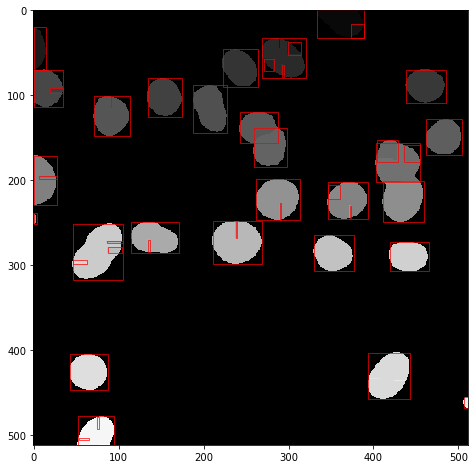

In [22]:
watershed_filter2, local_maxi = Segmentation_by_maxi(8)

In [192]:
# Choose watershed labels: option 1 vs 2
watershed_labels = watershed_filter2

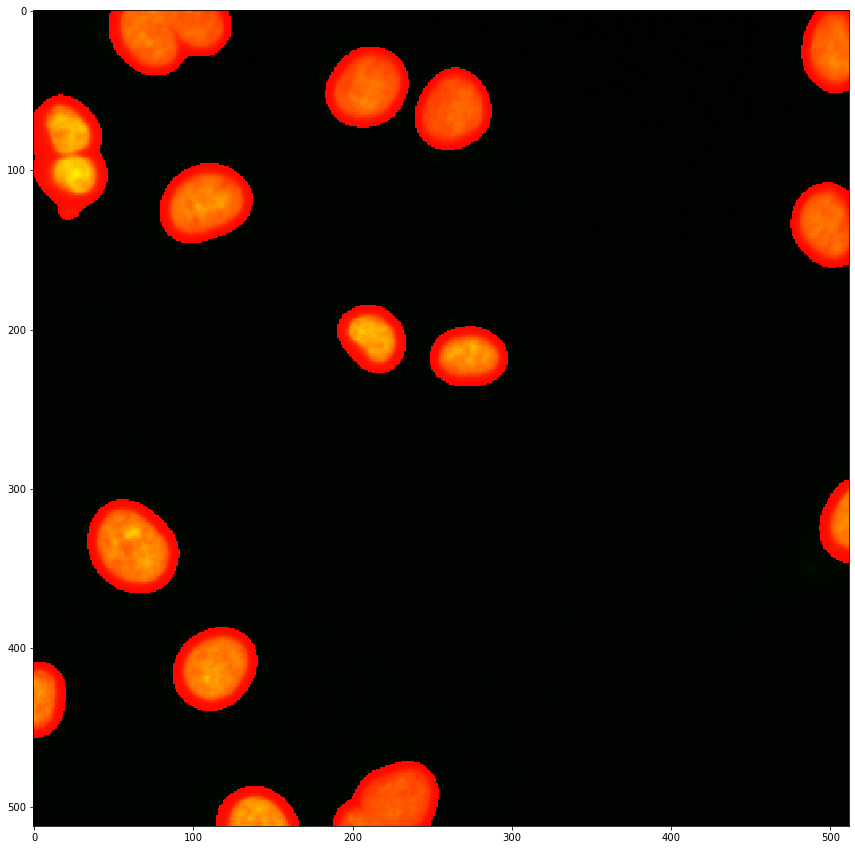

In [174]:
plt.figure(figsize=(15,15));plt.imshow(mh.as_rgb((watershed_labels!=0)*255/2, dna_max,0))

### Cleaning up regions
Remove cells touching the border <b>(Optional)</b>:

In [193]:
watershed_labels = mh.labeled.remove_bordering(watershed_labels);
print('Number of objects', len(np.unique(watershed_labels)))
#plt.imshow(watershed_labels, cmap=plt.cm.nipy_spectral)

Number of objects 22


In [200]:
#remove things that are too small to be a cell
sizes = mh.labeled.labeled_size(watershed_labels);
def size_filter(min_size = 18**2):
    print("filtering {}...".format(min_size))
    labels = mh.labeled.remove_regions_where(watershed_labels, sizes < min_size)
    print('Number of objects',len(np.unique(labels)))
    #plt.figure(figsize=(10,8)); plt.imshow(labels, cmap = plt.cm.nipy_spectral)
    return labels

In [201]:
final_labels = size_filter(0**2)

filtering 0...
Number of objects 22


21


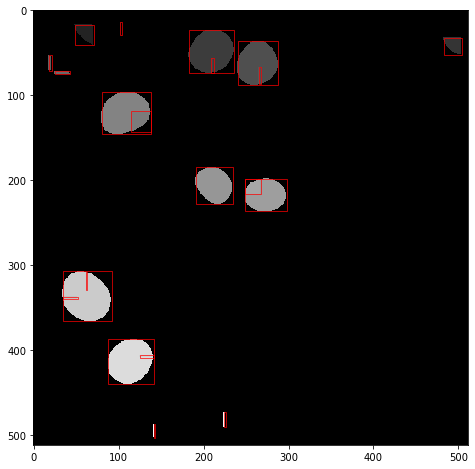

In [202]:
boxes = Label_boxer(final_labels, min_size=0**2); print(len(boxes))

<b> Output Segmentation

In [124]:
from skimage.segmentation import find_boundaries

In [125]:
# Using boxes and local contrasting methods to deliver image of nuclear segments:
def isLabelSurround(surround_img, label):
    for row in surround_img:
        for pixel_label in row:
            if pixel_label == label:
                return True
            else:
                return False
            
def Labeled2Nuclear(img, cell_labels, cell_boxes, method = 'Bin_Thres', local_contrast_radius = 2, output_coords = False):
    img_native = img.copy(); output_coords = {}
    
    if method == 'Bin_Thres':
        bin_nuclear_img = np.full(img.shape, False, dtype= bool)
        for label, box in cell_boxes.items(): # Cell
            (x_min, y_min, x_max, y_max) = box; img_ex = img[x_min:x_max, y_min: y_max]  # Made an image out of bbox
            # Local contrast and bin threshold
            enh_ex = mh.stretch(enhance_contrast(img_ex, disk(local_contrast_radius)))
            hist_intensity = np.histogram(enh_ex); thres_bin = hist_intensity[1][-2]
            coords = np.where(enh_ex > thres_bin);   # print('bbox nuclear', coords, 'bbox', box)
            nuclear_real_coordinates = np.add(coords, np.array([[x_min],[y_min]]))
            bin_nuclear_img[nuclear_real_coordinates[0],nuclear_real_coordinates[1]] = True
        return bin_nuclear_img
    elif method == 'Local_boundary':
        bin_boundary_img = np.full(img.shape, False, dtype= bool)
        for label, box in cell_boxes.items(): # Cell
            (x_min, y_min, x_max, y_max) = box; label_ex = cell_labels[x_min:x_max, y_min: y_max]  # Made an image out of bbox
            boundaries_bin = find_boundaries(label_ex, connectivity=1, mode='thick', background=0)
            coords = np.where(boundaries_bin ==True);
            real_bound_coords = np.add(coords, np.array([[x_min],[y_min]]))
            bin_boundary_img[real_bound_coords[0], real_bound_coords[1]] = True
        return bin_boundary_img
    elif method == 'Show_boundary':
        boundaries_bin = find_boundaries(cell_labels, connectivity=1, mode='thick', background=0)
        return boundaries_bin

In [93]:
# Return binary image of nuclei
#bin_nuclear_img = Labeled2Nuclear(img = dna_max, cell_labels = final_labels, cell_boxes = boxes)
# or
bin_boundary_img = Labeled2Nuclear(img = filtered_img, cell_labels = final_labels, cell_boxes = boxes, method = 'Show_boundary')

# Save a Copy

In [107]:
import PIL.Image as pil

In [108]:
filename = "BK69_Dapi_boundary-2.tif"
im = pil.fromarray(bin_boundary_img); im.save(filename)